**APPENDIX G**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import random
 
import statsmodels.api as sm
 
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
 
# Import Keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM
 
# Import Prophet
from fbprophet import Prophet
# Import VAR Model
from statsmodels.tsa.vector_ar.var_model import VAR
 
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df = pd.read_csv('Aotizhongxin1 - Copy (3) - Copy.csv')
df.head()

No  year  month  day  hour  PM2.5  ...    O3  TEMP    PRES  DEWP  RAIN  WSPM
0   1  2013      3    1     0    4.0  ...  77.0  -0.7  1023.0 -18.8   0.0   4.4
1   2  2013      3    1     1    8.0  ...  77.0  -1.1  1023.2 -18.2   0.0   4.7
2   3  2013      3    1     2    7.0  ...  73.0  -1.1  1023.5 -18.2   0.0   5.6
3   4  2013      3    1     3    6.0  ...  72.0  -1.4  1024.5 -19.4   0.0   3.1
4   5  2013      3    1     4    3.0  ...  72.0  -2.0  1025.2 -19.5   0.0   2.0

[5 rows x 16 columns]

In [ ]:
df['date'] = df[['year', 'month', 'day', 'hour']].apply(lambda row: f"{row['year']}-{row['month']}-{row['day']} {row['hour']}:00:00", axis=1)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df.head()

No  year  month  day  hour  ...    PRES  DEWP  RAIN  WSPM                date
0   1  2013      3    1     0  ...  1023.0 -18.8   0.0   4.4 2013-03-01 00:00:00
1   2  2013      3    1     1  ...  1023.2 -18.2   0.0   4.7 2013-03-01 01:00:00
2   3  2013      3    1     2  ...  1023.5 -18.2   0.0   5.6 2013-03-01 02:00:00
3   4  2013      3    1     3  ...  1024.5 -19.4   0.0   3.1 2013-03-01 03:00:00
4   5  2013      3    1     4  ...  1025.2 -19.5   0.0   2.0 2013-03-01 04:00:00

[5 rows x 17 columns]

In [ ]:

df.drop(['No','year','month','day','hour'], axis=1, inplace=True)
df.head()

PM2.5  PM10   SO2   NO2     CO  ...    PRES  DEWP  RAIN  WSPM                date
0    4.0   4.0   4.0   7.0  300.0  ...  1023.0 -18.8   0.0   4.4 2013-03-01 00:00:00
1    8.0   8.0   4.0   7.0  300.0  ...  1023.2 -18.2   0.0   4.7 2013-03-01 01:00:00
2    7.0   7.0   5.0  10.0  300.0  ...  1023.5 -18.2   0.0   5.6 2013-03-01 02:00:00
3    6.0   6.0  11.0  11.0  300.0  ...  1024.5 -19.4   0.0   3.1 2013-03-01 03:00:00
4    3.0   3.0  12.0  12.0  300.0  ...  1025.2 -19.5   0.0   2.0 2013-03-01 04:00:00

[5 rows x 12 columns]

In [ ]:
df.sort_values(by='date', inplace=True)
df.head()

PM2.5  PM10   SO2   NO2     CO  ...    PRES  DEWP  RAIN  WSPM                date
0    4.0   4.0   4.0   7.0  300.0  ...  1023.0 -18.8   0.0   4.4 2013-03-01 00:00:00
1    8.0   8.0   4.0   7.0  300.0  ...  1023.2 -18.2   0.0   4.7 2013-03-01 01:00:00
2    7.0   7.0   5.0  10.0  300.0  ...  1023.5 -18.2   0.0   5.6 2013-03-01 02:00:00
3    6.0   6.0  11.0  11.0  300.0  ...  1024.5 -19.4   0.0   3.1 2013-03-01 03:00:00
4    3.0   3.0  12.0  12.0  300.0  ...  1025.2 -19.5   0.0   2.0 2013-03-01 04:00:00

[5 rows x 12 columns]

In [ ]:
df['date'].min(), df['date'].max()

(Timestamp('2013-03-01 00:00:00'), Timestamp('2017-02-28 23:00:00'))

In [ ]:
df.set_index('date', inplace=True)
df.head()

PM2.5  PM10   SO2   NO2  ...    PRES  DEWP  RAIN  WSPM
date                                          ...                          
2013-03-01 00:00:00    4.0   4.0   4.0   7.0  ...  1023.0 -18.8   0.0   4.4
2013-03-01 01:00:00    8.0   8.0   4.0   7.0  ...  1023.2 -18.2   0.0   4.7
2013-03-01 02:00:00    7.0   7.0   5.0  10.0  ...  1023.5 -18.2   0.0   5.6
2013-03-01 03:00:00    6.0   6.0  11.0  11.0  ...  1024.5 -19.4   0.0   3.1
2013-03-01 04:00:00    3.0   3.0  12.0  12.0  ...  1025.2 -19.5   0.0   2.0

[5 rows x 11 columns]

In [ ]:
# Data grouped Month-wise
grpd_df = df.resample('MS').mean()
print(grpd_df.shape)
grpd_df.head()

(48, 11)


PM2.5        PM10        SO2  ...       DEWP      RAIN      WSPM
date                                           ...                               
2013-03-01  110.092742  144.147849  44.834608  ...  -5.729435  0.026210  2.000134
2013-04-01   62.751389  108.204167  24.733914  ...  -1.553611  0.015139  2.209722
2013-05-01   85.090502  140.778226  30.442204  ...   9.790457  0.007796  1.740457
2013-06-01  106.179167  128.716667  14.474761  ...  18.009028  0.130694  1.240000
2013-07-01   68.911290   85.391129   9.284144  ...  21.459946  0.293817  1.278763

[5 rows x 11 columns]

In [ ]:
df['2013-03-01']['PM2.5'].mean()

7.125

In [ ]:
df['PM2.5'].fillna(method='ffill', inplace=True)
df['PM2.5'].fillna(value=df['2013-03-01']['PM2.5'].mean(), inplace=True)
df.head()

PM2.5  PM10   SO2   NO2  ...    PRES  DEWP  RAIN  WSPM
date                                          ...                          
2013-03-01 00:00:00    4.0   4.0   4.0   7.0  ...  1023.0 -18.8   0.0   4.4
2013-03-01 01:00:00    8.0   8.0   4.0   7.0  ...  1023.2 -18.2   0.0   4.7
2013-03-01 02:00:00    7.0   7.0   5.0  10.0  ...  1023.5 -18.2   0.0   5.6
2013-03-01 03:00:00    6.0   6.0  11.0  11.0  ...  1024.5 -19.4   0.0   3.1
2013-03-01 04:00:00    3.0   3.0  12.0  12.0  ...  1025.2 -19.5   0.0   2.0

[5 rows x 11 columns]

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 16, 6

def plot_pred_date(pred):
    pred = pd.DataFrame(sc.inverse_transform(pred), columns=df.columns, index=valid.index)
    temp = pd.DataFrame(sc.inverse_transform(train), columns=train.columns, index=train.index)
    
    for col in temp.columns:
        plt.plot(temp[col], 'r-', label='Actual Data')
        plt.plot(pred[col], 'b-', label='Predicted Data')
        plt.legend()
        plt.xlabel('Date')
        plt.ylabel(col)
        plt.title(f'Predicted {col} vs DateTime')
        plt.show()
        
    return


def plot_actual_pred(pred):
    pred = pd.DataFrame(sc.inverse_transform(pred), columns=df.columns, index=valid.index)
    temp = pd.DataFrame(sc.inverse_transform(valid), columns=valid.columns, index=valid.index)

    for col in temp.columns:
        plt.plot(temp[col], 'r-', label='Actual Data')
        plt.plot(pred[col], 'b-', label='Predicted Data')
        plt.legend()
        plt.xlabel('Date')
        plt.ylabel(col)
        plt.title(f'Actual {col} vs Predicted {col}')
        plt.show()
        
    return

In [ ]:
d_train = df[:int(0.7*(len(df)))]
d_valid = df[int(0.7*(len(df))):]

In [ ]:
sc = StandardScaler()
sc.fit(d_train)
train = pd.DataFrame(sc.transform(d_train), columns=df.columns, index=d_train.index)
valid = pd.DataFrame(sc.transform(d_valid), columns=df.columns, index=d_valid.index)

In [ ]:
n_input = len(train.columns)
n_features= len(train.columns)
generator = TimeseriesGenerator(train.values, train.values, length=n_input, batch_size=10)
test_data = np.vstack((train[-n_input:], valid.values))
valid_generator = TimeseriesGenerator(test_data, test_data, length=n_input, batch_size=len(test_data))

In [ ]:
d_train = df[:int(0.7*(len(df)))]
d_valid = df[int(0.7*(len(df))):]


sc = StandardScaler()
sc.fit(d_train)
train = pd.DataFrame(sc.transform(d_train), columns=df.columns, index=d_train.index)
valid = pd.DataFrame(sc.transform(d_valid), columns=df.columns, index=d_valid.index)



n_input = len(train.columns)
n_features= len(train.columns)
generator = TimeseriesGenerator(train.values, train.values, length=n_input, batch_size=10)
test_data = np.vstack((train[-n_input:], valid.values))
valid_generator = TimeseriesGenerator(test_data, test_data, length=n_input, batch_size=len(test_data))


from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, RMSprop, Adam

lstm_model = Sequential()
lstm_model.add(LSTM(500, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(100, activation='relu'))
lstm_model.add(Dense(11))
lstm_model.compile(SGD(lr=1e-06), loss='mse')

lstm_model.summary()



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 11, 500)           1024000   
_________________________________________________________________
lstm_5 (LSTM)                (None, 200)               560800    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_5 (Dense)              (None, 11)                1111      
Total params: 1,606,011
Trainable params: 1,606,011
Non-trainable params: 0
_________________________________________________________________


In [ ]:

history = lstm_model.fit_generator(generator,epochs=40)

Epoch 1/40
2454/2454 [==============================] - 569s 231ms/step - loss: 1.0337
Epoch 2/40
2454/2454 [==============================] - 502s 204ms/step - loss: 1.0151
Epoch 3/40
2454/2454 [==============================] - 616s 251ms/step - loss: 0.9962
Epoch 4/40
2454/2454 [==============================] - 619s 252ms/step - loss: 0.9777
Epoch 5/40
2454/2454 [==============================] - 589s 240ms/step - loss: 0.9902
Epoch 6/40
2454/2454 [==============================] - 587s 239ms/step - loss: 1.0350
Epoch 7/40
2454/2454 [==============================] - 609s 248ms/step - loss: 0.9964
Epoch 8/40
2454/2454 [==============================] - 610s 249ms/step - loss: 1.0030
Epoch 9/40
2454/2454 [==============================] - 587s 239ms/step - loss: 1.0211
Epoch 10/40
2454/2454 [==============================] - 599s 244ms/step - loss: 1.0125
Epoch 11/40
2454/2454 [==============================] - 614s 250ms/step - loss: 0.9790
Epoch 12/40
2454/2454 [==================

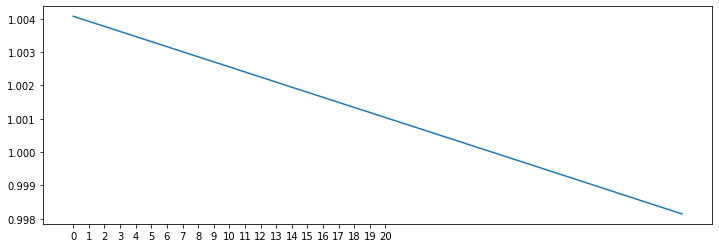

In [ ]:
losses_lstm = lstm_model.history.history['loss']

plt.figure(figsize=(12,4))
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [ ]:
lstm_predictions_scaled = list()

batch = train[-n_input:]
current_batch = batch.values.reshape((1, n_input, n_features))

for i in range(len(valid)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]], axis=1)



predictions = lstm_model.predict_generator(valid_generator)
predictions.shape, valid.shape

((10520, 11), (10520, 11))

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
lstm_pred = pd.DataFrame(predictions, columns=df.columns)

#check rmse
for i in df.columns:
    try:
        print('RMSE value for', i, 'is : ', np.sqrt(mean_squared_error(lstm_pred[i], valid[i])))
        print('MSE value for', i, 'is : ', (mean_squared_error(lstm_pred[i], valid[i])))
        print('MAE value for', i, 'is : ', (mean_absolute_error(lstm_pred[i], valid[i])))
        print('R2 value for', i, 'is : ', (r2_score(lstm_pred[i], valid[i])))
    except Exception as err:
        print(i, err)

RMSE value for PM2.5 is :  1.1114036640268914
MSE value for PM2.5 is :  1.235218104412399
MAE value for PM2.5 is :  0.8151701940141779
R2 value for PM2.5 is :  -1158.7534729758365
RMSE value for PM10 is :  1.0388944110954472
MSE value for PM10 is :  1.079301597405356
MAE value for PM10 is :  0.788329744954675
R2 value for PM10 is :  -2029.610338411994
RMSE value for SO2 is :  0.7247306214929405
MSE value for SO2 is :  0.5252344737295438
MAE value for SO2 is :  0.5910399404504147
R2 value for SO2 is :  -627.4286459187819
RMSE value for NO2 is :  1.0788804572832476
MSE value for NO2 is :  1.1639830411077092
MAE value for NO2 is :  0.8979428558229254
R2 value for NO2 is :  -1606.9304683961293
RMSE value for CO is :  1.3293358979639402
MSE value for CO is :  1.7671339296155952
MAE value for CO is :  0.8476920146046327
R2 value for CO is :  -1967.8232697935255
RMSE value for O3 is :  1.0028870774195098
MSE value for O3 is :  1.0057824900550458
MAE value for O3 is :  0.7471427112914419
R2 va

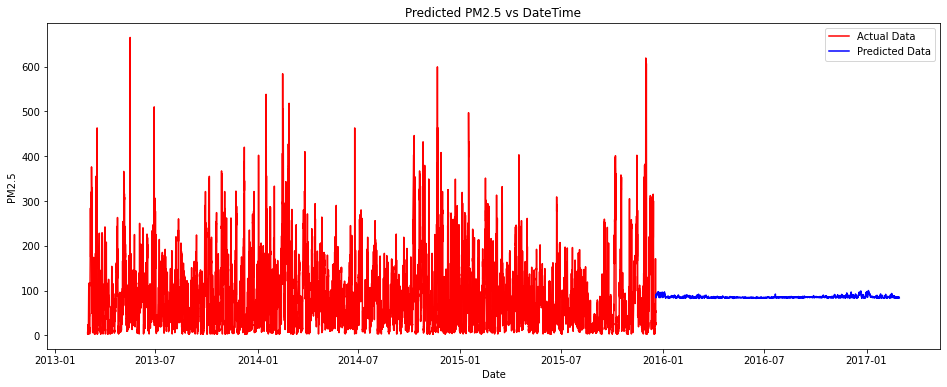

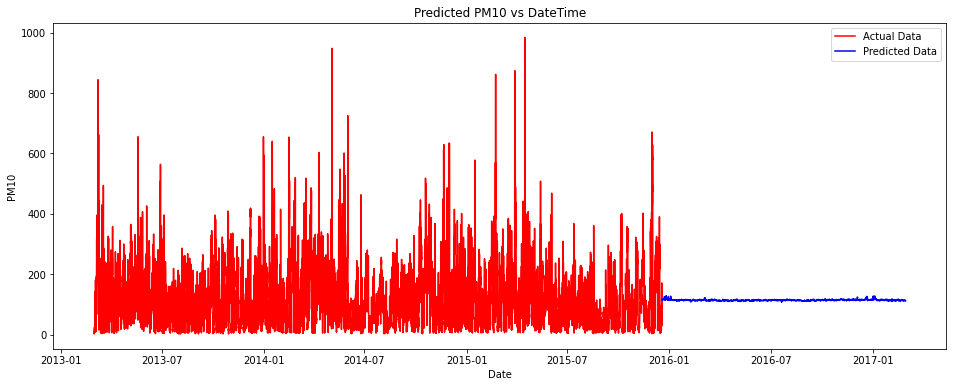

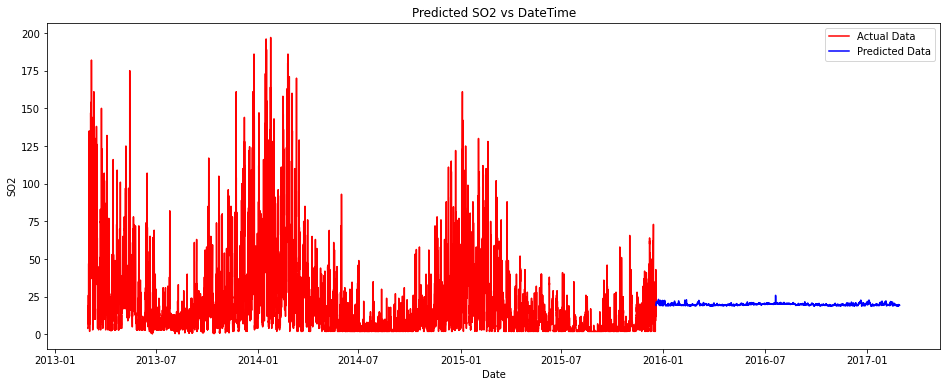

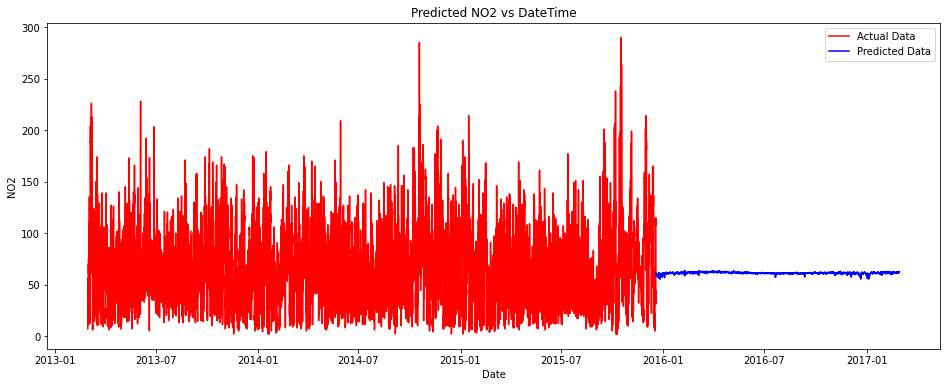

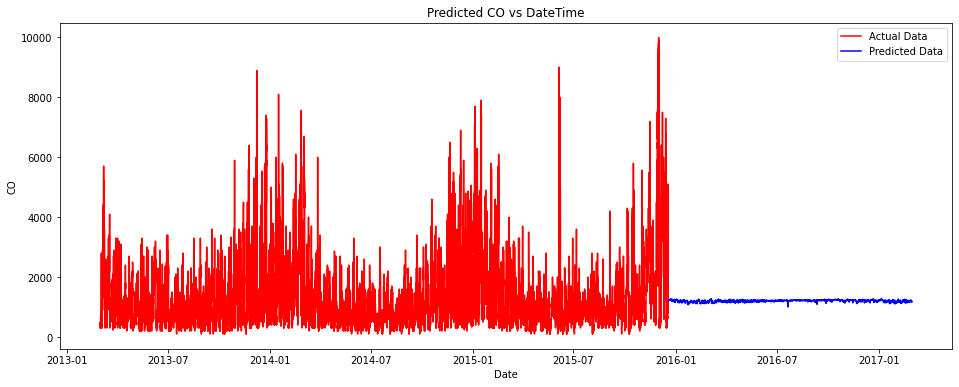

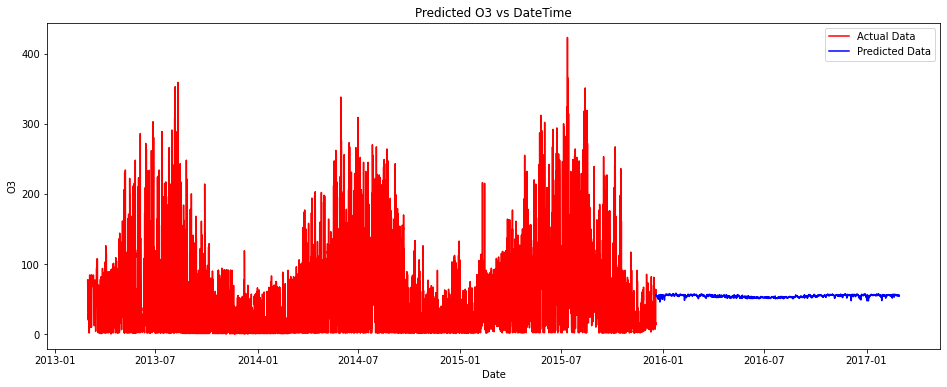

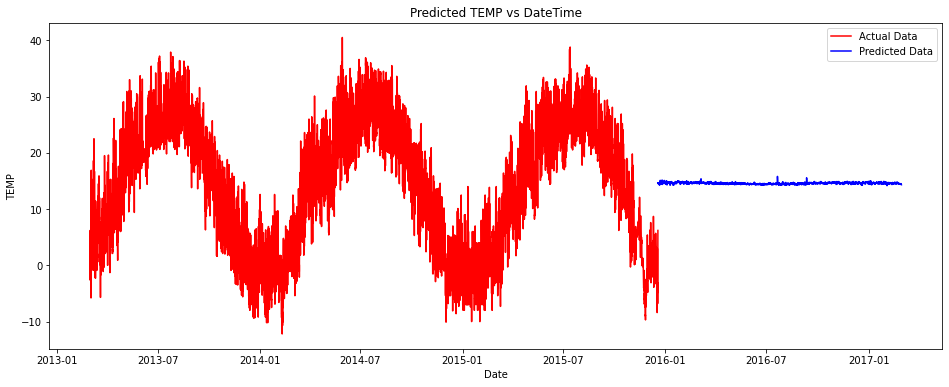

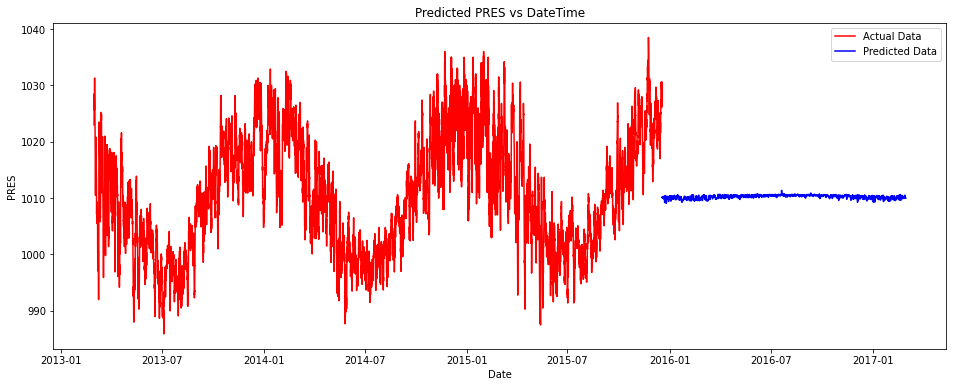

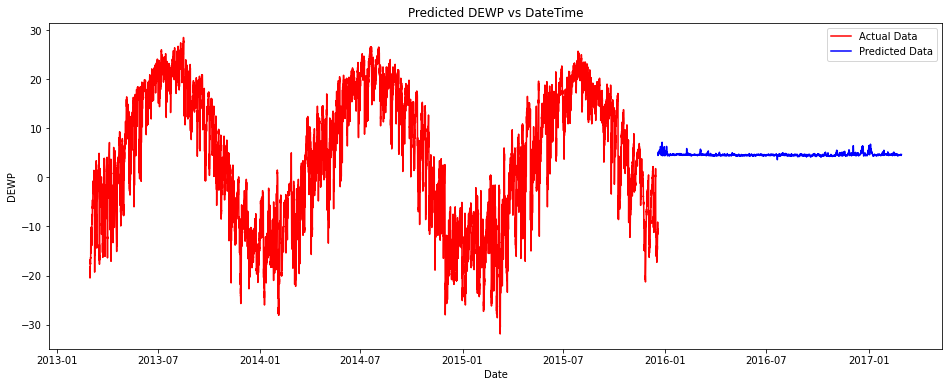

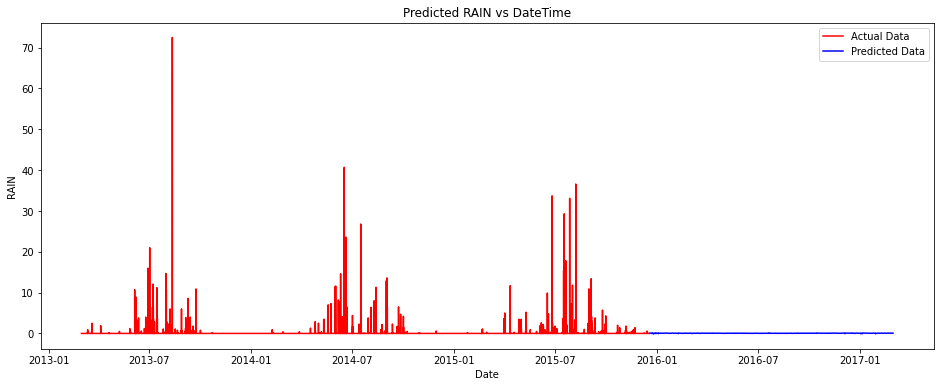

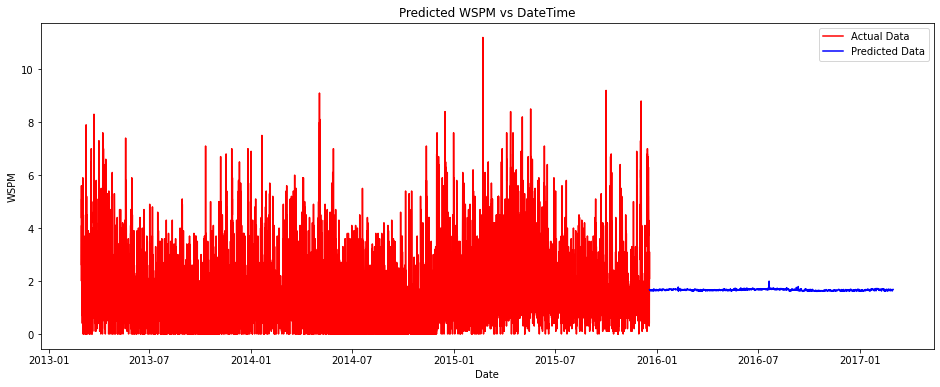

In [ ]:
plot_pred_date(lstm_pred)

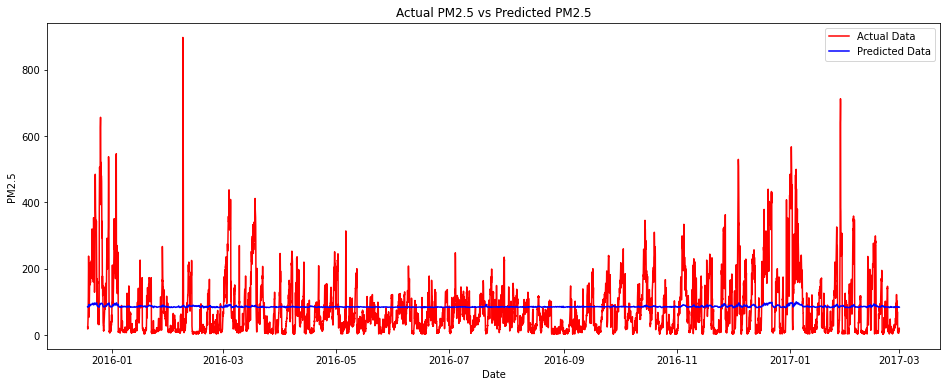

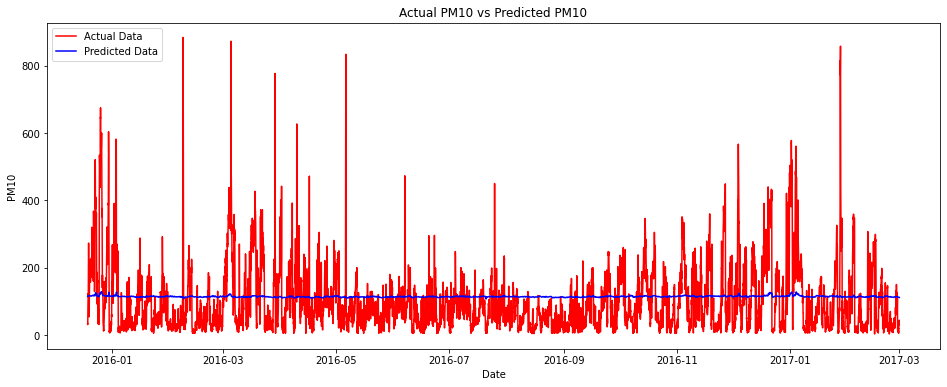

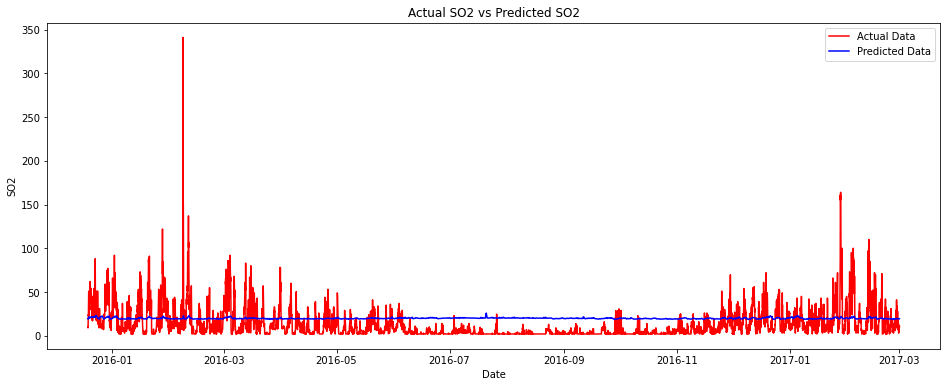

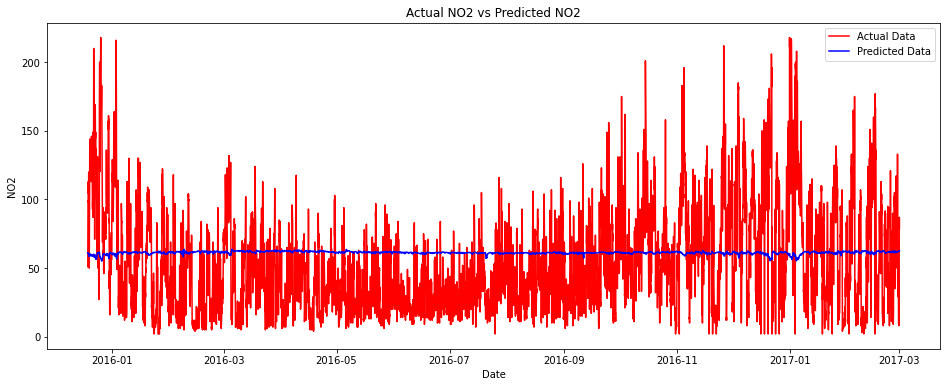

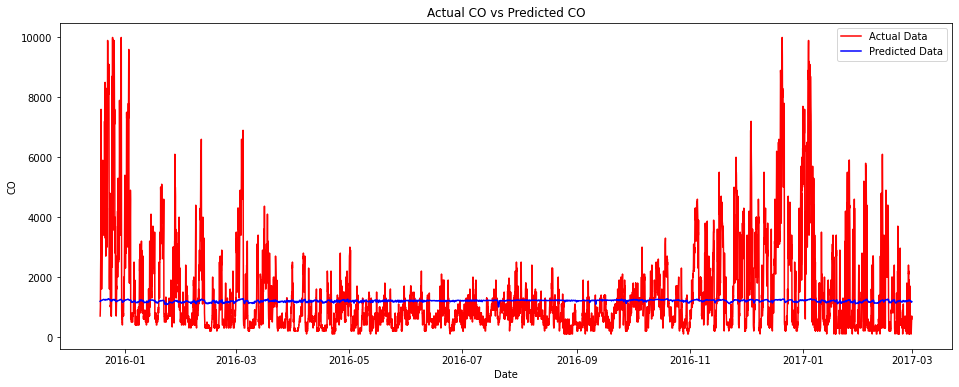

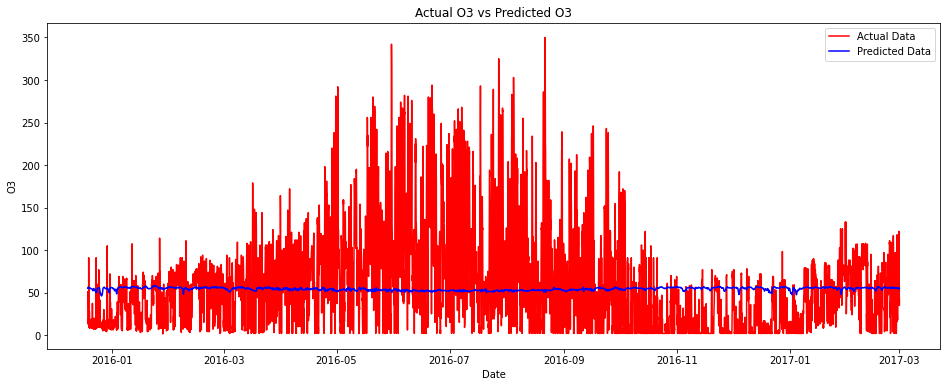

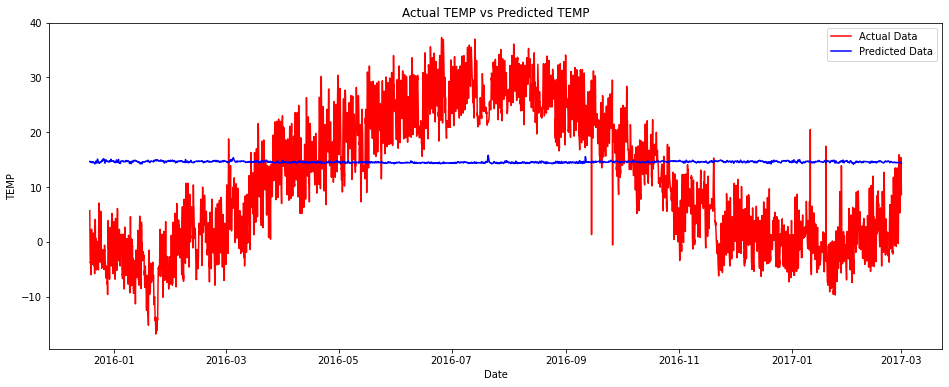

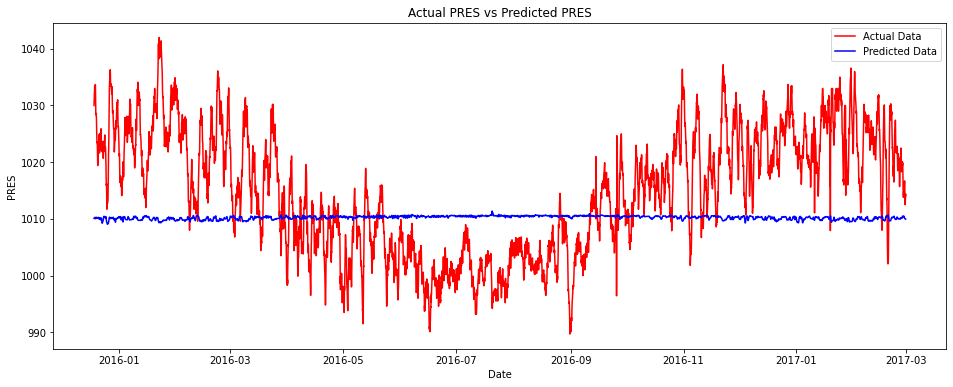

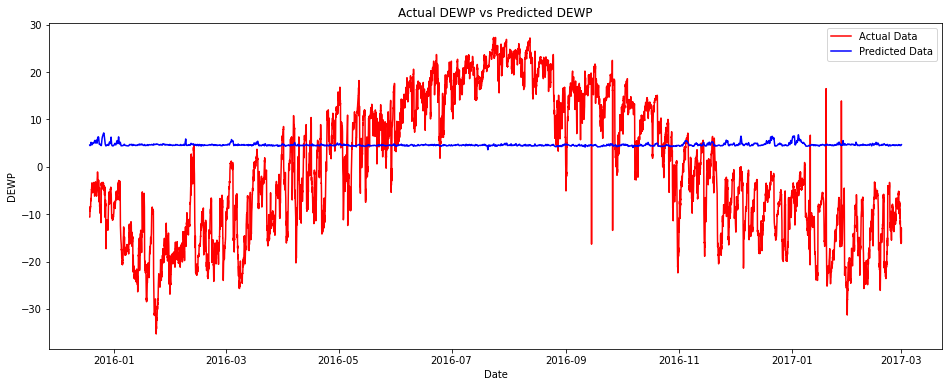

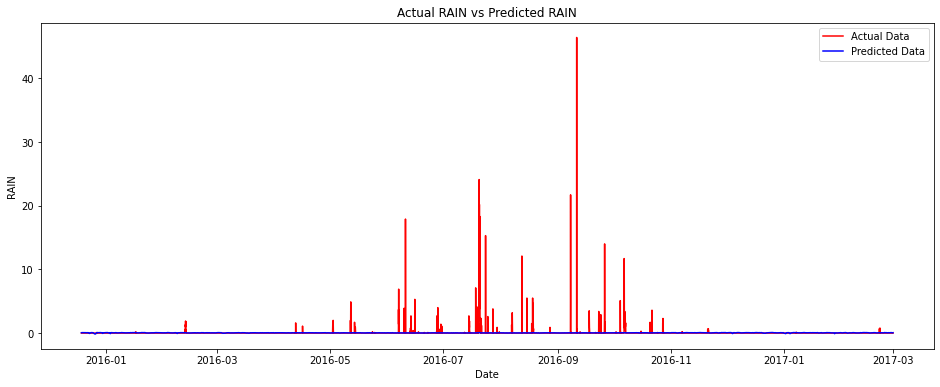

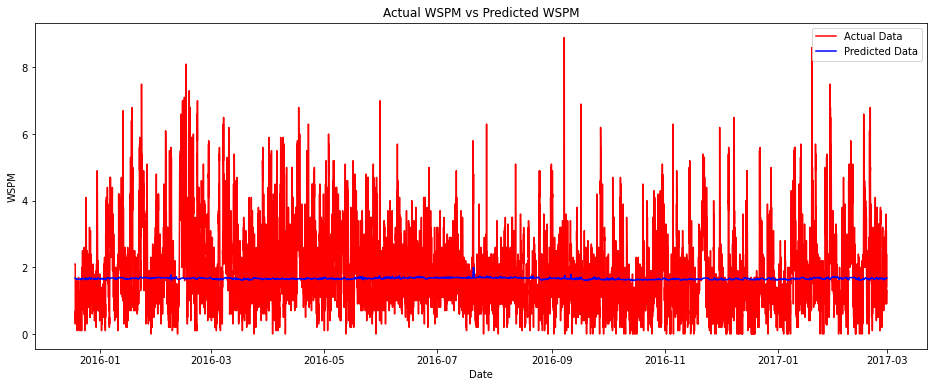

In [ ]:
plot_actual_pred(lstm_pred)

In [ ]:
d_train = df[:int(0.7*(len(df)))]
d_valid = df[int(0.7*(len(df))):]


sc = StandardScaler()
sc.fit(d_train)
train = pd.DataFrame(sc.transform(d_train), columns=df.columns, index=d_train.index)
valid = pd.DataFrame(sc.transform(d_valid), columns=df.columns, index=d_valid.index)



n_input = len(train.columns)
n_features= len(train.columns)
generator = TimeseriesGenerator(train.values, train.values, length=n_input, batch_size=10)
test_data = np.vstack((train[-n_input:], valid.values))
valid_generator = TimeseriesGenerator(test_data, test_data, length=n_input, batch_size=len(test_data))


from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, RMSprop, Adam

lstm_model = Sequential()
lstm_model.add(LSTM(500, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(100, activation='relu'))
lstm_model.add(Dense(11))
lstm_model.compile(RMSprop(lr=1e-06), loss='mse' )

lstm_model.summary()



Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 11, 500)           1024000   
_________________________________________________________________
lstm_7 (LSTM)                (None, 200)               560800    
_________________________________________________________________
dense_6 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_7 (Dense)              (None, 11)                1111      
Total params: 1,606,011
Trainable params: 1,606,011
Non-trainable params: 0
_________________________________________________________________


In [ ]:

history = lstm_model.fit_generator(generator,epochs=40)

Epoch 1/40
2454/2454 [==============================] - 401s 162ms/step - loss: 0.9506
Epoch 2/40
2454/2454 [==============================] - 396s 161ms/step - loss: 0.9204
Epoch 3/40
2454/2454 [==============================] - 397s 162ms/step - loss: 0.8752
Epoch 4/40
2454/2454 [==============================] - 424s 173ms/step - loss: 0.8220
Epoch 5/40
2454/2454 [==============================] - 394s 161ms/step - loss: 0.7267
Epoch 6/40
2454/2454 [==============================] - 380s 155ms/step - loss: 0.6456
Epoch 7/40
2454/2454 [==============================] - 381s 155ms/step - loss: 0.6050
Epoch 8/40
2454/2454 [==============================] - 391s 159ms/step - loss: 0.6123
Epoch 9/40
2454/2454 [==============================] - 361s 147ms/step - loss: 0.6055
Epoch 10/40
2454/2454 [==============================] - 383s 156ms/step - loss: 0.6260
Epoch 11/40
2454/2454 [==============================] - 386s 157ms/step - loss: 0.7234
Epoch 12/40
2454/2454 [==================

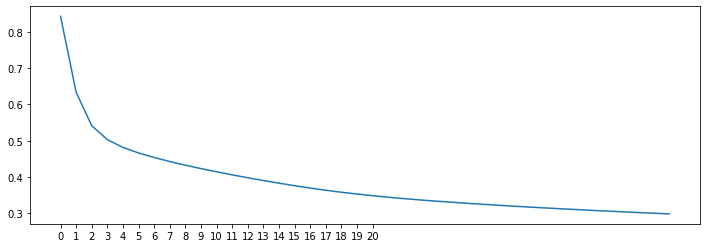

In [ ]:
losses_lstm = lstm_model.history.history['loss']

plt.figure(figsize=(12,4))
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [ ]:
lstm_predictions_scaled = list()

batch = train[-n_input:]
current_batch = batch.values.reshape((1, n_input, n_features))

for i in range(len(valid)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred)
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]], axis=1)



predictions = lstm_model.predict_generator(valid_generator)
predictions.shape, valid.shape


from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
lstm_pred = pd.DataFrame(predictions, columns=df.columns)

#check rmse
for i in df.columns:
    try:
        print('RMSE value for', i, 'is : ', np.sqrt(mean_squared_error(lstm_pred[i], valid[i])))
        print('MSE value for', i, 'is : ', (mean_squared_error(lstm_pred[i], valid[i])))
        print('MAE value for', i, 'is : ', (mean_absolute_error(lstm_pred[i], valid[i])))
        print('R2 value for', i, 'is : ', (r2_score(lstm_pred[i], valid[i],  multioutput='variance_weighted')))
    except Exception as err:
        print(i, err)
   

RMSE value for PM2.5 is :  0.5273891107444034
MSE value for PM2.5 is :  0.27813927413177264
MAE value for PM2.5 is :  0.30429552369526697
R2 value for PM2.5 is :  0.6316658213341932
RMSE value for PM10 is :  0.5615657696728493
MSE value for PM10 is :  0.3153561136682596
MAE value for PM10 is :  0.3450273392820527
R2 value for PM10 is :  0.44745664427725285
RMSE value for SO2 is :  0.39530137655307185
MSE value for SO2 is :  0.1562631783047535
MAE value for SO2 is :  0.23880143516503233
R2 value for SO2 is :  0.5707496559545182
RMSE value for NO2 is :  0.5434765695380648
MSE value for NO2 is :  0.295366781636863
MAE value for NO2 is :  0.4094414744988924
R2 value for NO2 is :  0.589092780843683
RMSE value for CO is :  0.6181922749060889
MSE value for CO is :  0.3821616887535653
MAE value for CO is :  0.3479554939031902
R2 value for CO is :  0.6341416837874698
RMSE value for O3 is :  0.48737740567509996
MSE value for O3 is :  0.23753673556259094
MAE value for O3 is :  0.3402506663682551


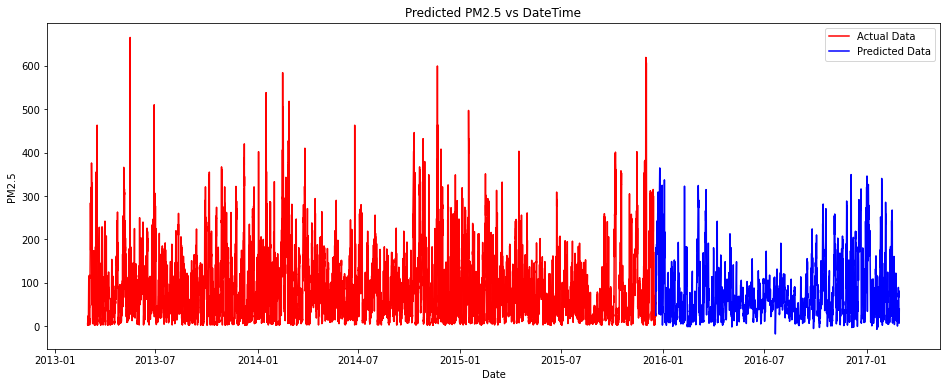

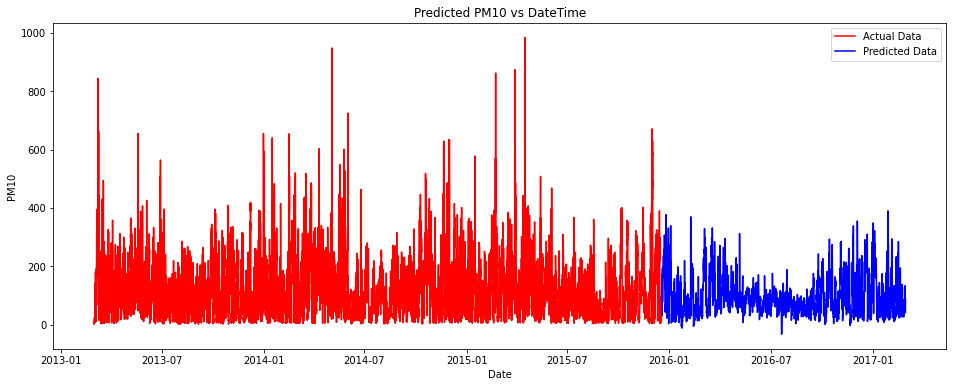

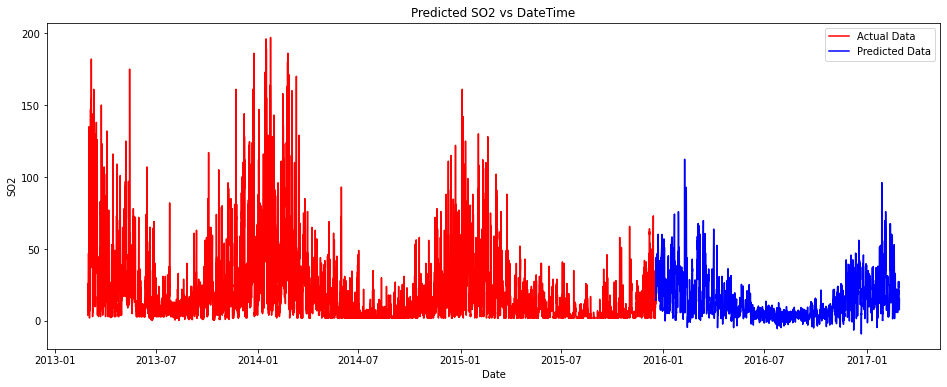

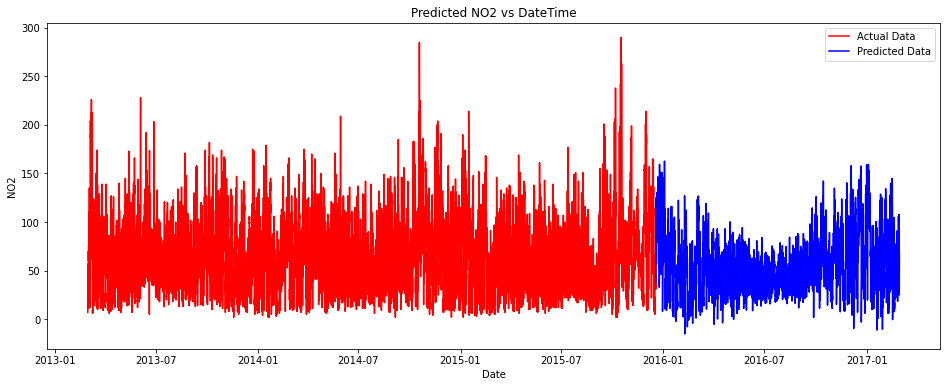

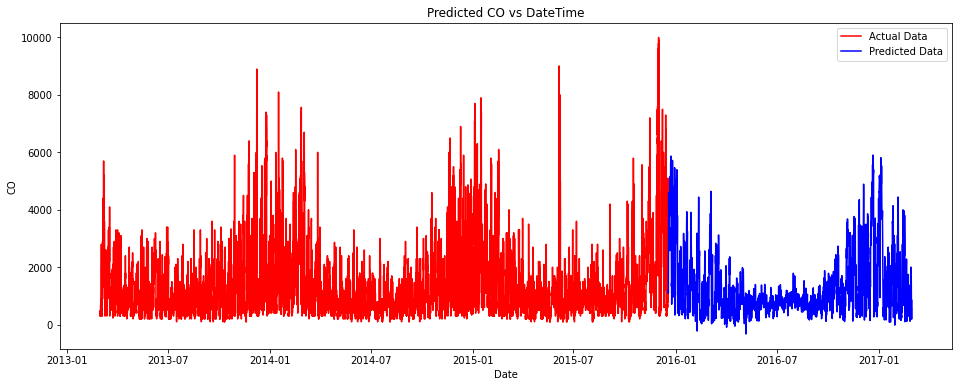

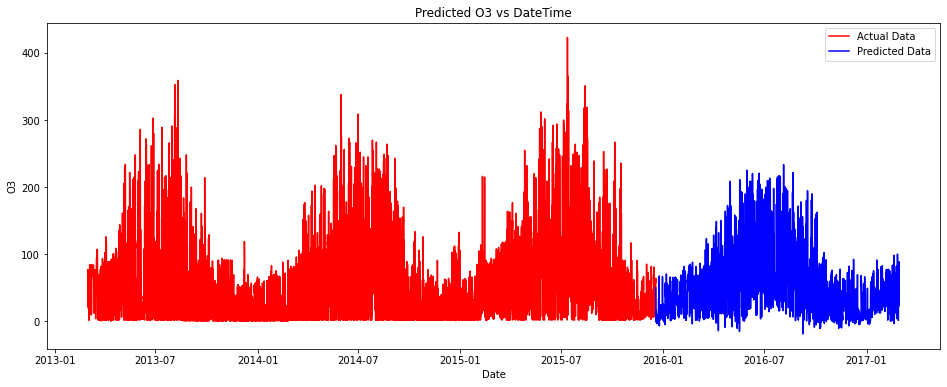

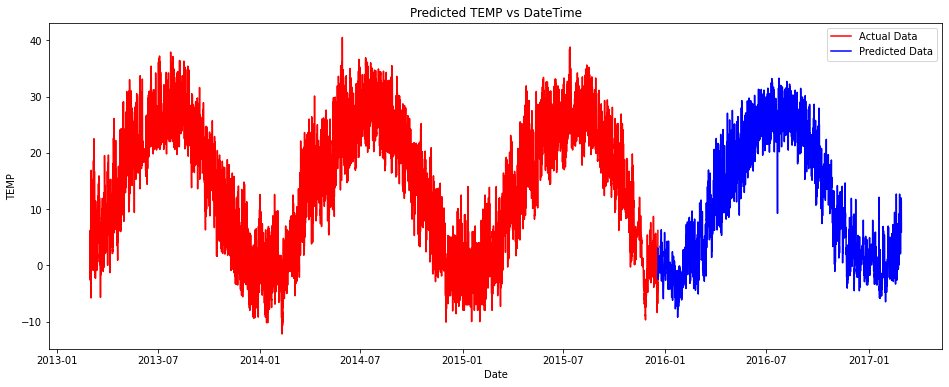

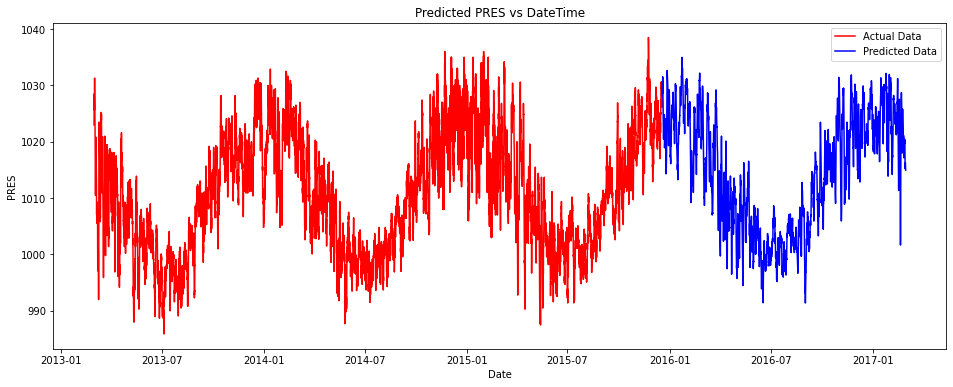

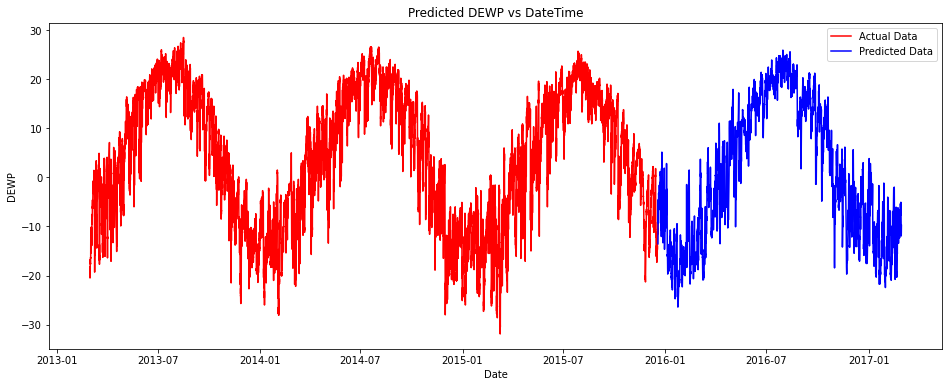

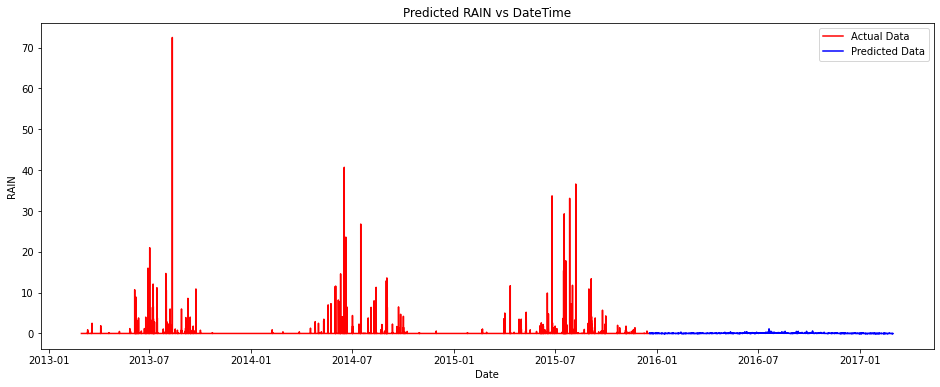

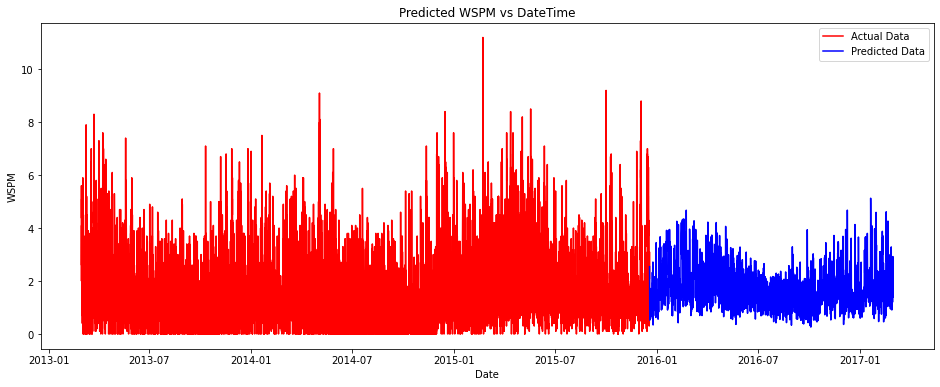

In [ ]:
plot_pred_date(lstm_pred)

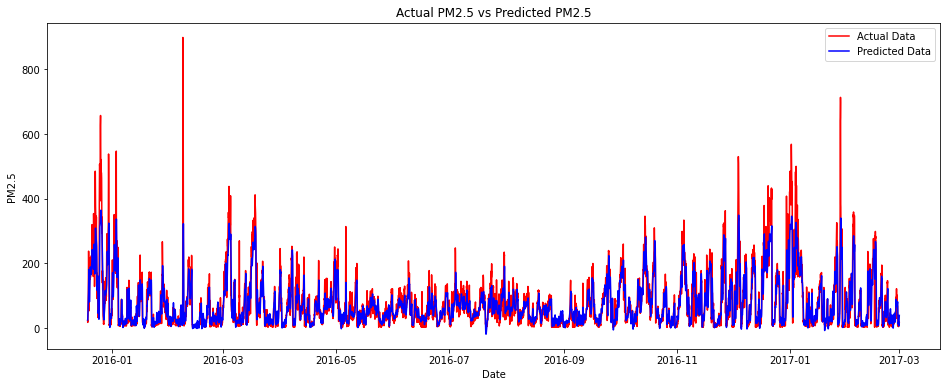

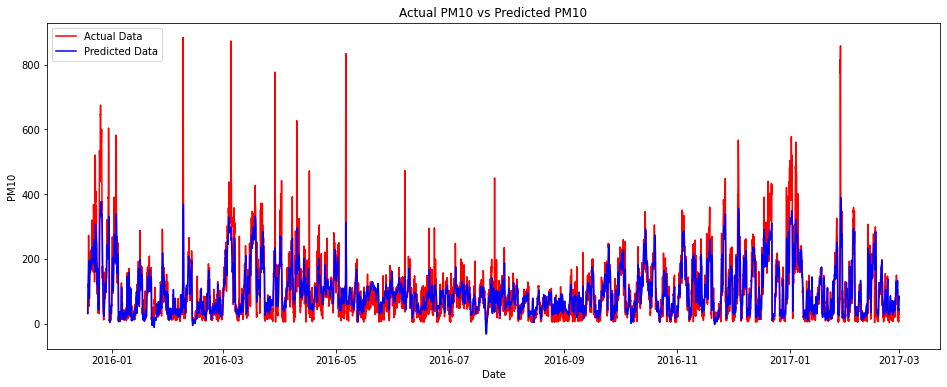

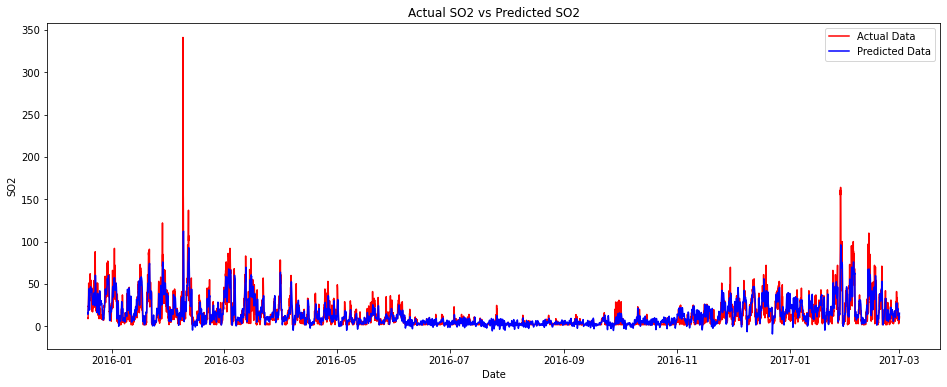

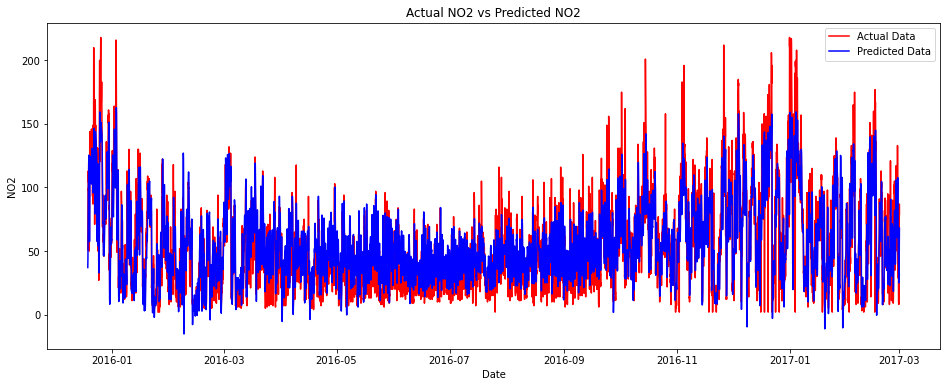

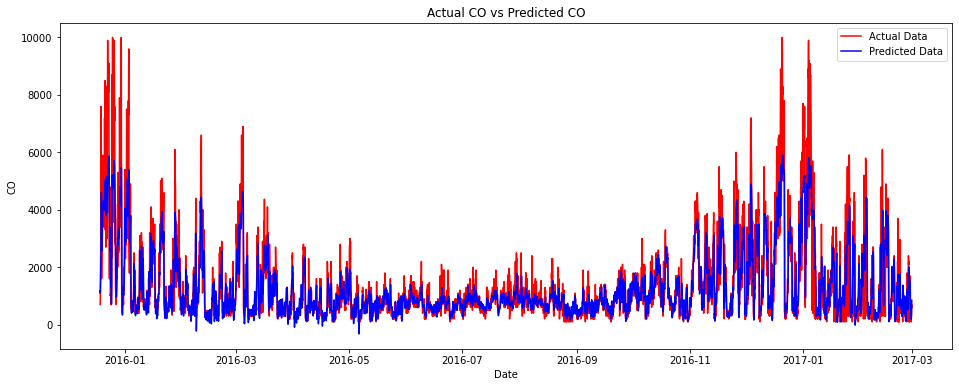

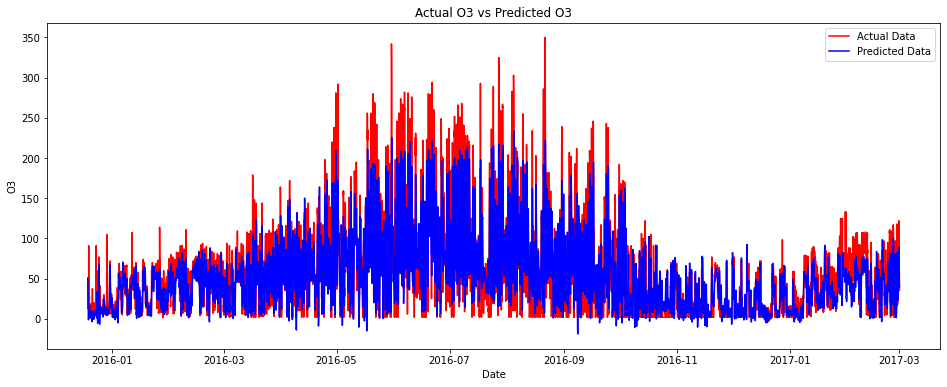

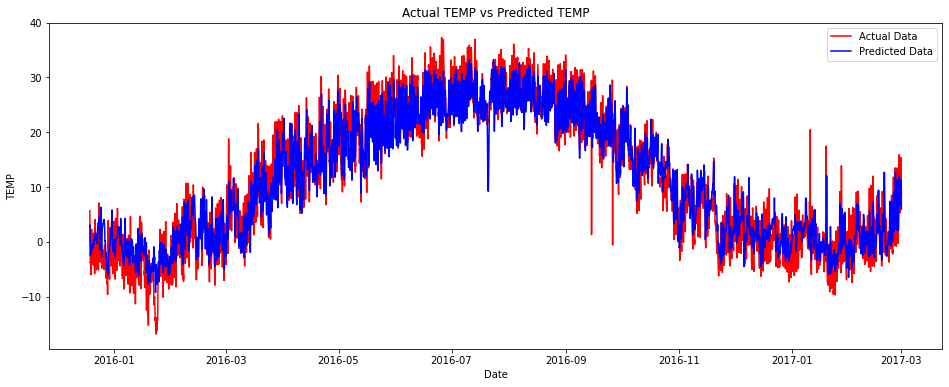

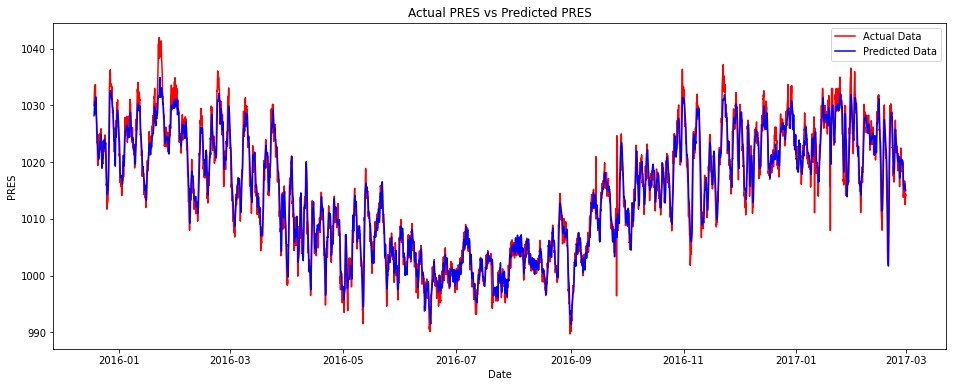

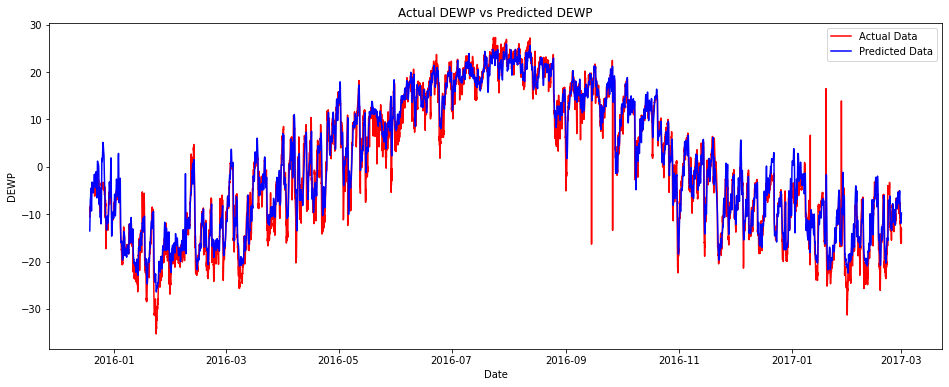

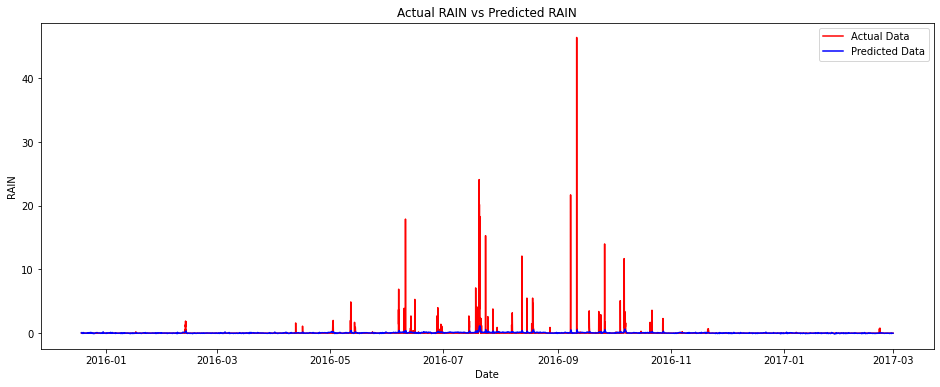

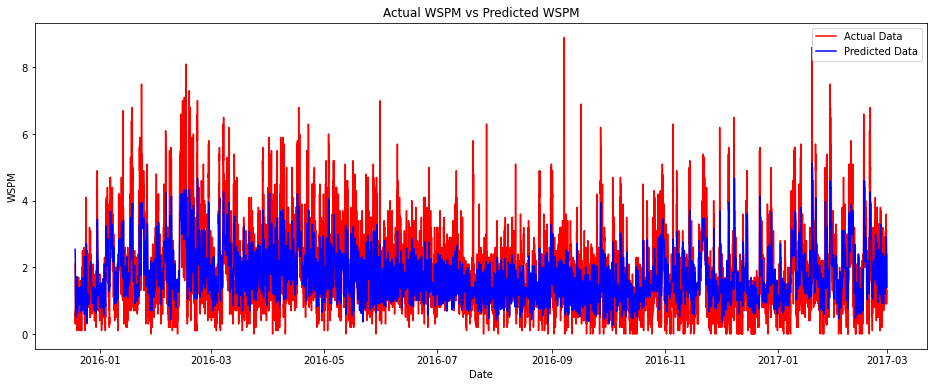

In [ ]:
plot_actual_pred(lstm_pred)

In [ ]:
d_train = df[:int(0.7*(len(df)))]
d_valid = df[int(0.7*(len(df))):]


sc = StandardScaler()
sc.fit(d_train)
train = pd.DataFrame(sc.transform(d_train), columns=df.columns, index=d_train.index)
valid = pd.DataFrame(sc.transform(d_valid), columns=df.columns, index=d_valid.index)



n_input = len(train.columns)
n_features= len(train.columns)
generator = TimeseriesGenerator(train.values, train.values, length=n_input, batch_size=10)
test_data = np.vstack((train[-n_input:], valid.values))
valid_generator = TimeseriesGenerator(test_data, test_data, length=n_input, batch_size=len(test_data))


from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, RMSprop, Adam

lstm_model = Sequential()
lstm_model.add(LSTM(500, activation='tanh', input_shape=(n_input, n_features), return_sequences=True))
lstm_model.add(LSTM(200, activation='tanh', input_shape=(n_input, n_features)))
lstm_model.add(Dense(100, activation='tanh'))
lstm_model.add(Dense(11))
lstm_model.compile(Adam(lr=1e-06), loss='mse' )

lstm_model.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 11, 500)           1024000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 200)               560800    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_3 (Dense)              (None, 11)                1111      
Total params: 1,606,011
Trainable params: 1,606,011
Non-trainable params: 0
_________________________________________________________________


In [ ]:

history = lstm_model.fit_generator(generator,epochs=40)

Epoch 1/40
2454/2454 [==============================] - 256s 103ms/step - loss: 0.9552
Epoch 2/40
2454/2454 [==============================] - 251s 102ms/step - loss: 0.7035
Epoch 3/40
2454/2454 [==============================] - 248s 101ms/step - loss: 0.5426
Epoch 4/40
2454/2454 [==============================] - 255s 104ms/step - loss: 0.5194
Epoch 5/40
2454/2454 [==============================] - 257s 105ms/step - loss: 0.4535
Epoch 6/40
2454/2454 [==============================] - 255s 104ms/step - loss: 0.4450
Epoch 7/40
2454/2454 [==============================] - 250s 102ms/step - loss: 0.4162
Epoch 8/40
2454/2454 [==============================] - 259s 106ms/step - loss: 0.4267
Epoch 9/40
2454/2454 [==============================] - 254s 104ms/step - loss: 0.3983
Epoch 10/40
2454/2454 [==============================] - 259s 106ms/step - loss: 0.3906
Epoch 11/40
2454/2454 [==============================] - 268s 109ms/step - loss: 0.3886
Epoch 12/40
2454/2454 [==================

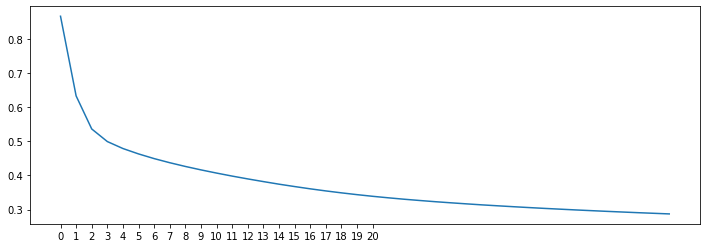

In [ ]:
losses_lstm = lstm_model.history.history['loss']

plt.figure(figsize=(12,4))
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [ ]:
lstm_predictions_scaled = list()

batch = train[-n_input:]
current_batch = batch.values.reshape((1, n_input, n_features))

for i in range(len(valid)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred)
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]], axis=1)



predictions = lstm_model.predict_generator(valid_generator)
predictions.shape, valid.shape


from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
lstm_pred = pd.DataFrame(predictions, columns=df.columns)

#check rmse
for i in df.columns:
    try:
        print('RMSE value for', i, 'is : ', np.sqrt(mean_squared_error(lstm_pred[i], valid[i])))
        print('MSE value for', i, 'is : ', (mean_squared_error(lstm_pred[i], valid[i])))
        print('MAE value for', i, 'is : ', (mean_absolute_error(lstm_pred[i], valid[i])))
        print('R2 value for', i, 'is : ', (r2_score(lstm_pred[i], valid[i],  multioutput='variance_weighted')))
    except Exception as err:
        print(i, err)
   

RMSE value for PM2.5 is :  0.46963162465493435
MSE value for PM2.5 is :  0.22055386287603312
MAE value for PM2.5 is :  0.2778658259715902
R2 value for PM2.5 is :  0.7464165670882559
RMSE value for PM10 is :  0.521252934208847
MSE value for PM10 is :  0.27170462142133256
MAE value for PM10 is :  0.32340867232438697
R2 value for PM10 is :  0.5987267127805024
RMSE value for SO2 is :  0.39029161852934824
MSE value for SO2 is :  0.15232754749425828
MAE value for SO2 is :  0.23814408497471667
R2 value for SO2 is :  0.5796994547147081
RMSE value for NO2 is :  0.5377817384004331
MSE value for NO2 is :  0.28920919815699186
MAE value for NO2 is :  0.4064084973668586
R2 value for NO2 is :  0.6145473789314123
RMSE value for CO is :  0.547445733127853
MSE value for CO is :  0.29969683071989245
MAE value for CO is :  0.3170144727499765
R2 value for CO is :  0.7588465300296133
RMSE value for O3 is :  0.48835790627554365
MSE value for O3 is :  0.23849344462183267
MAE value for O3 is :  0.3418593551535

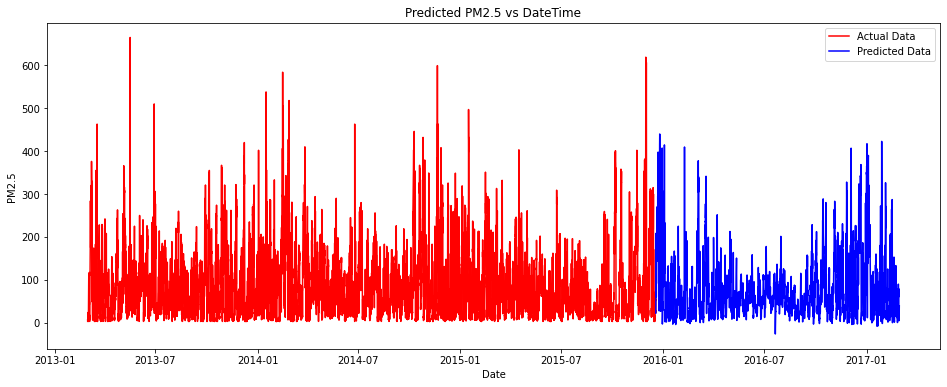

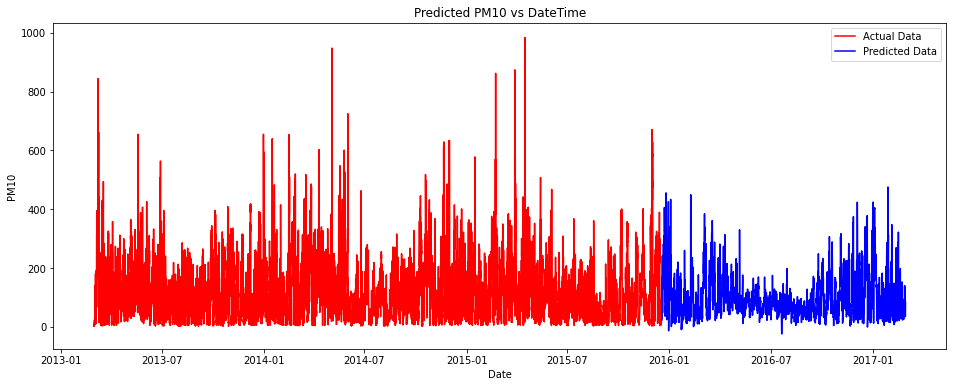

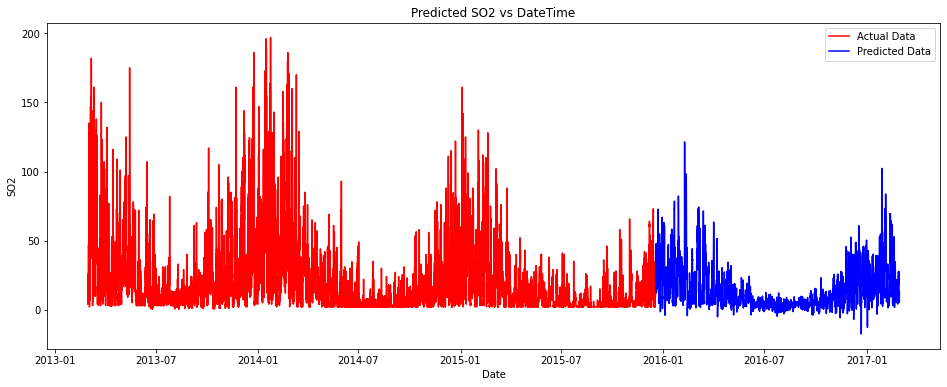

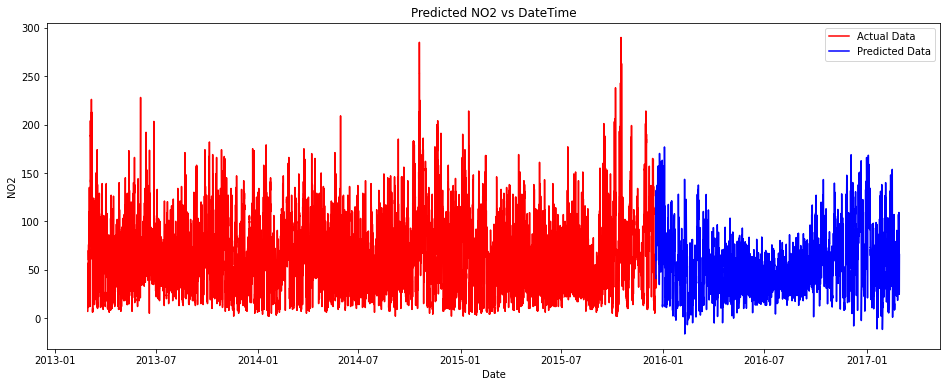

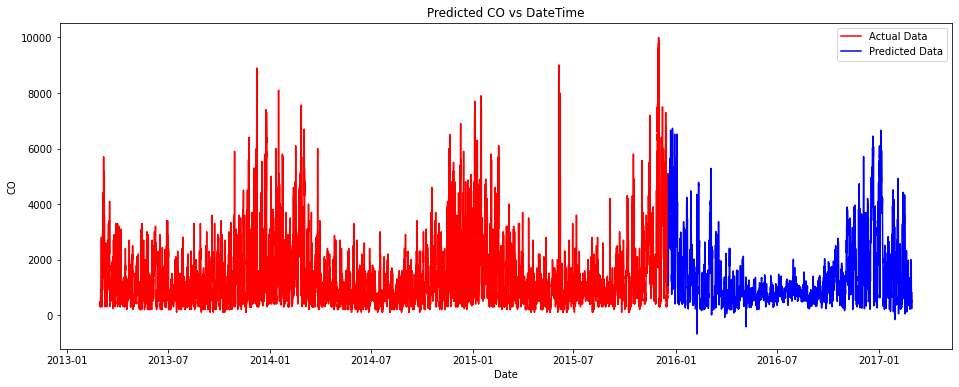

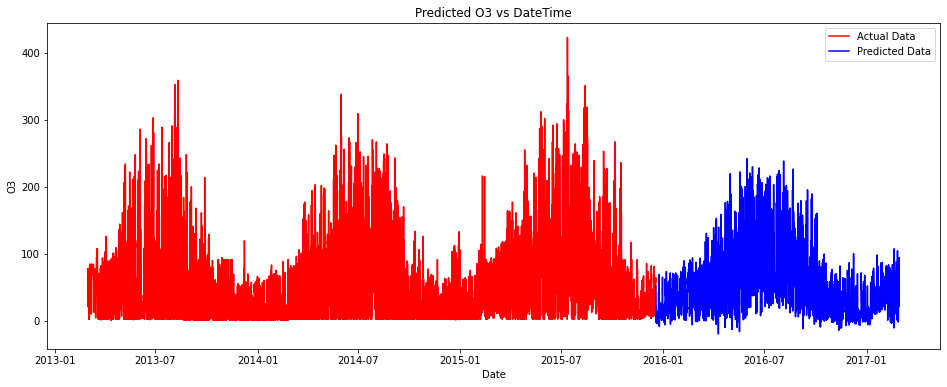

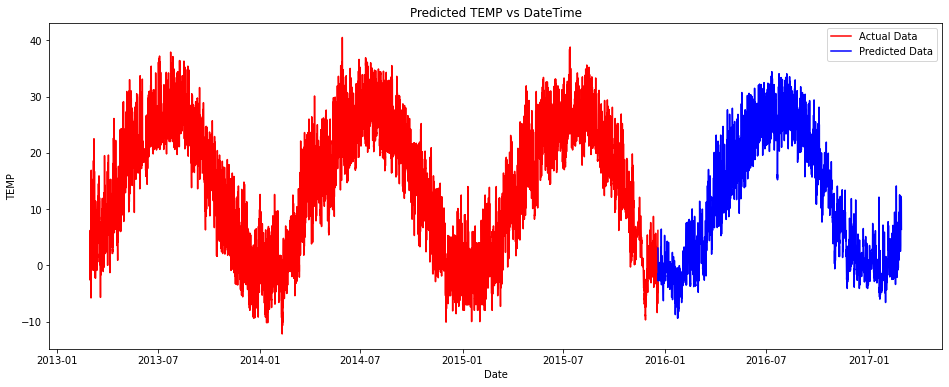

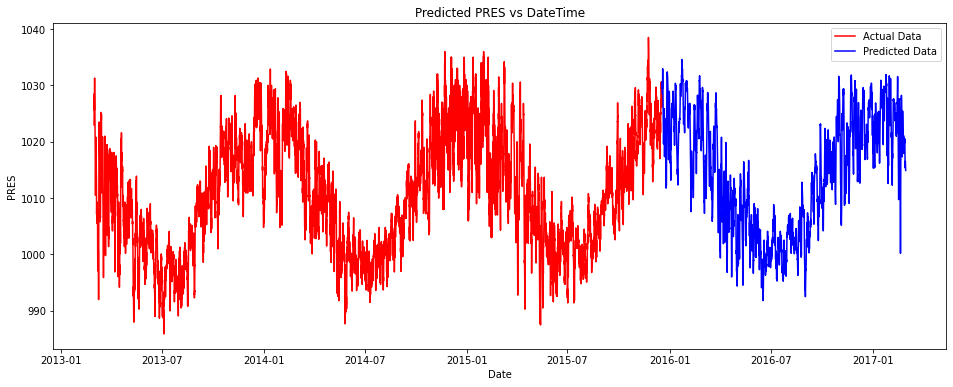

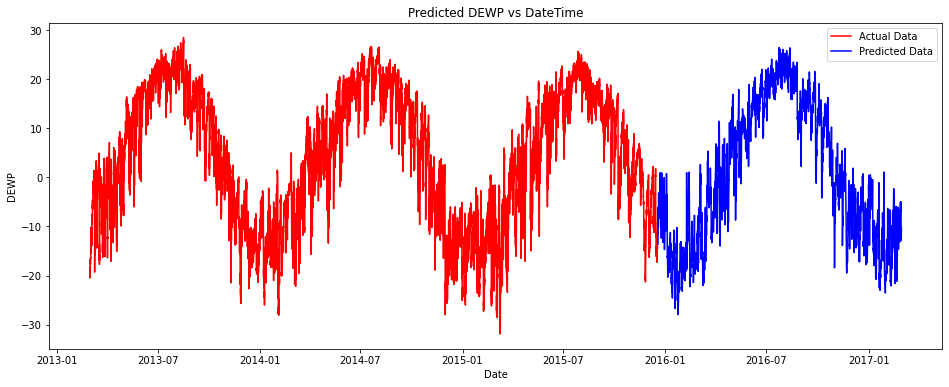

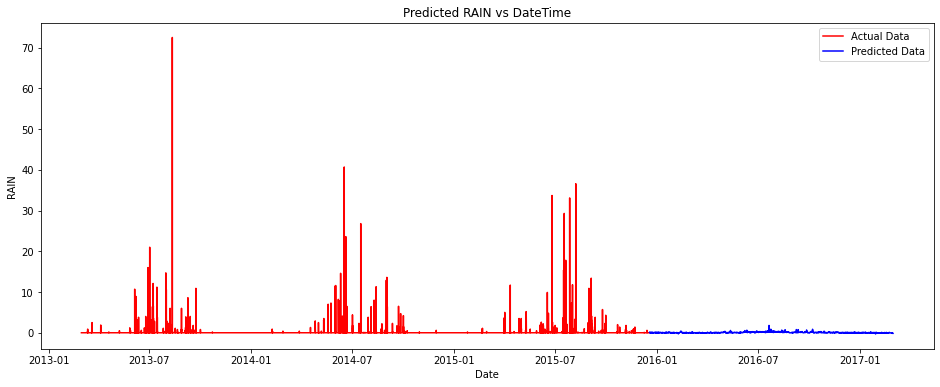

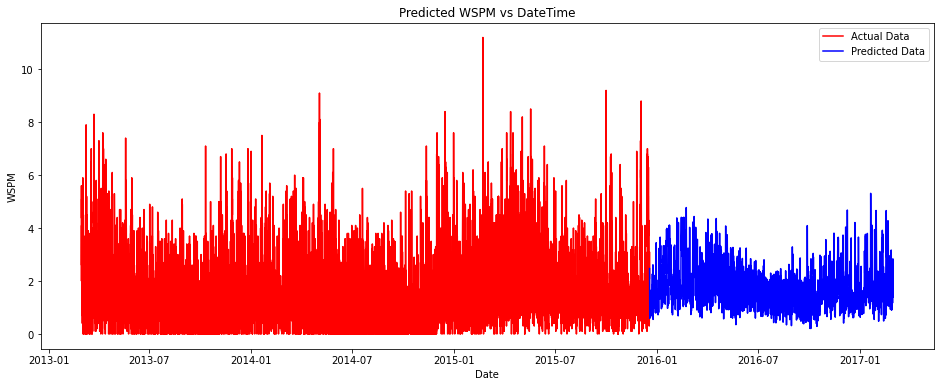

In [ ]:
plot_pred_date(lstm_pred)

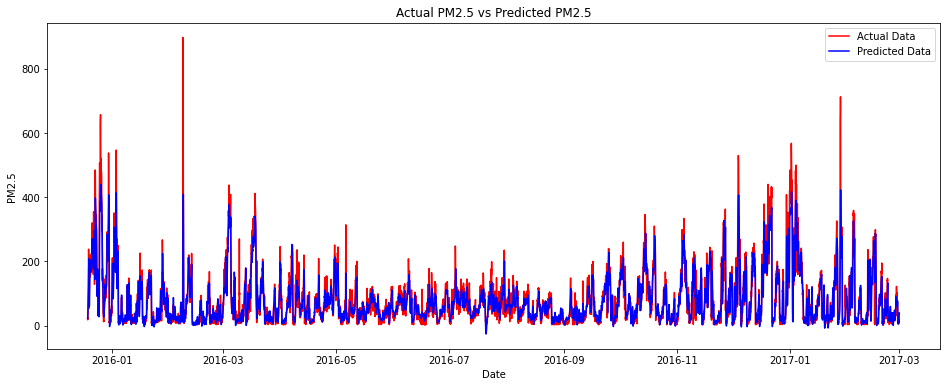

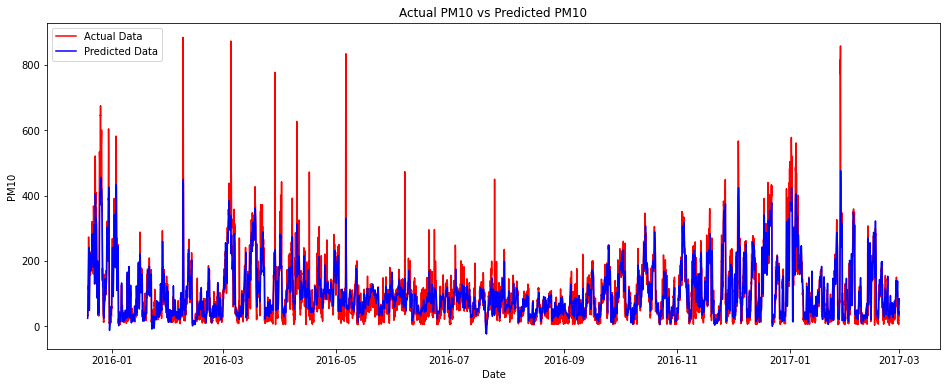

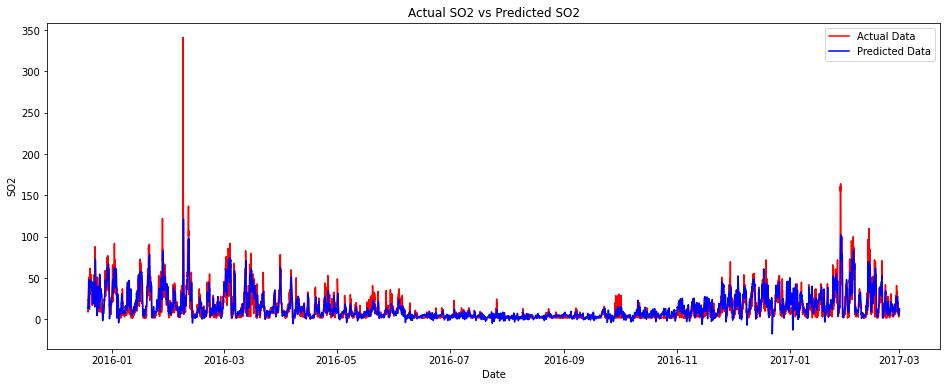

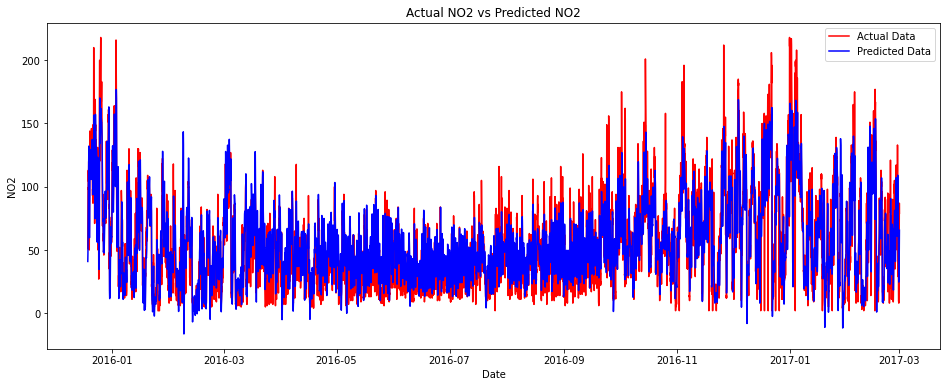

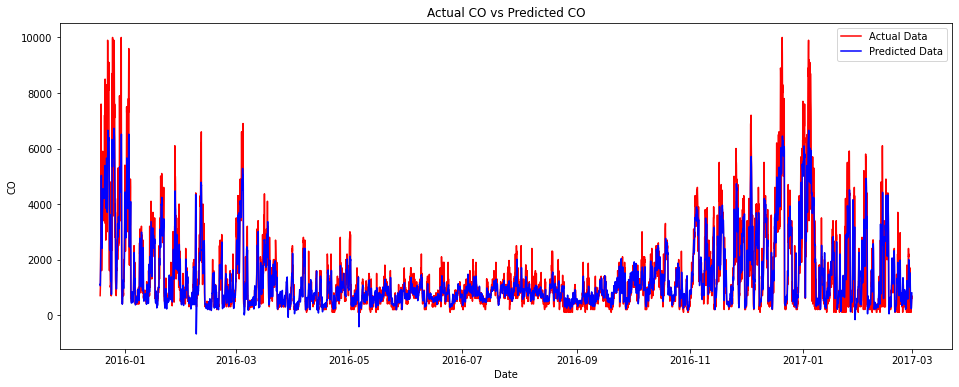

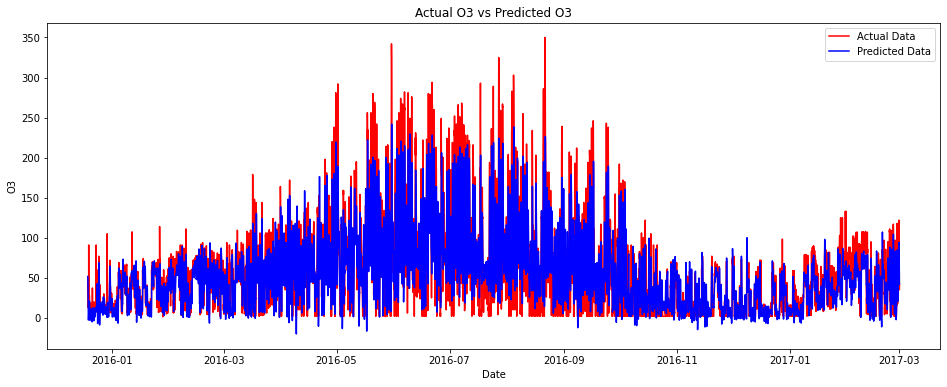

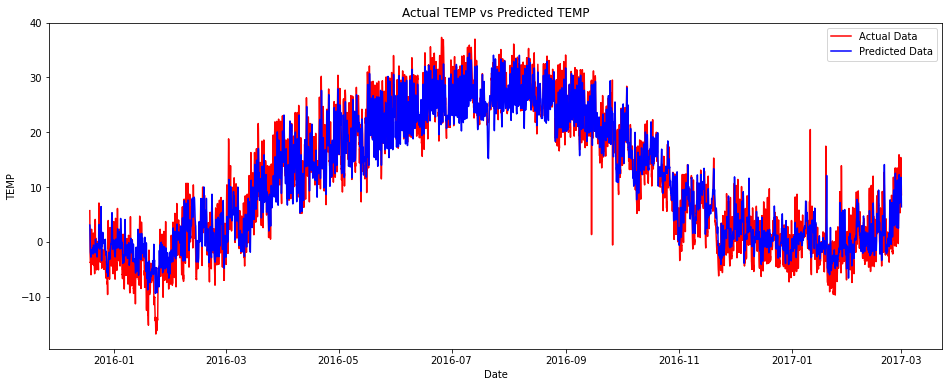

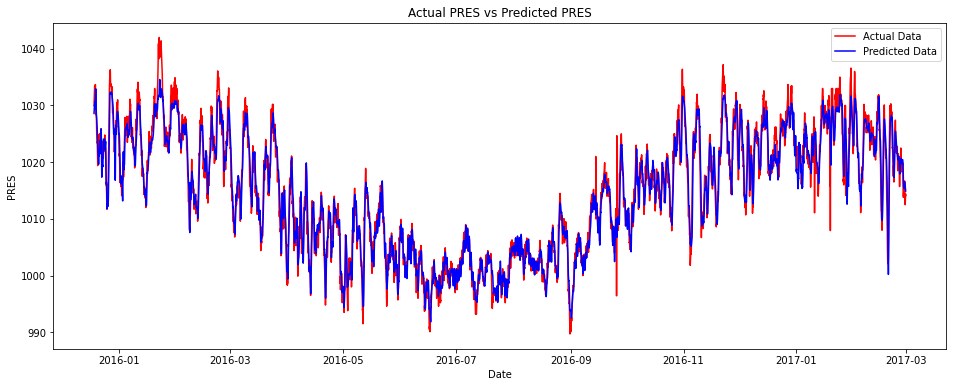

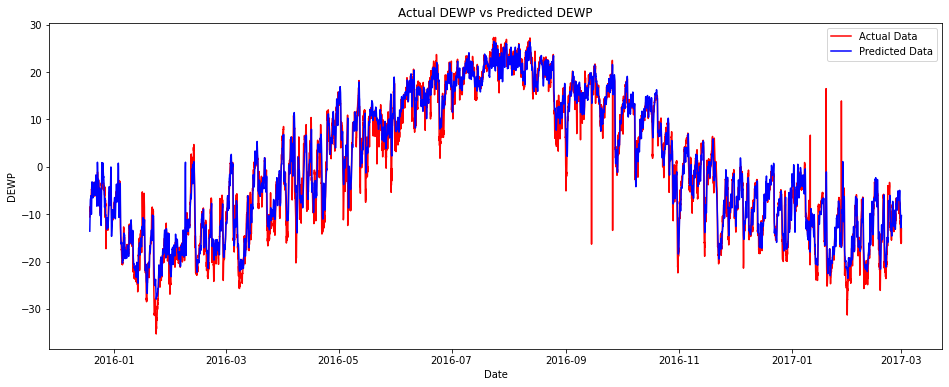

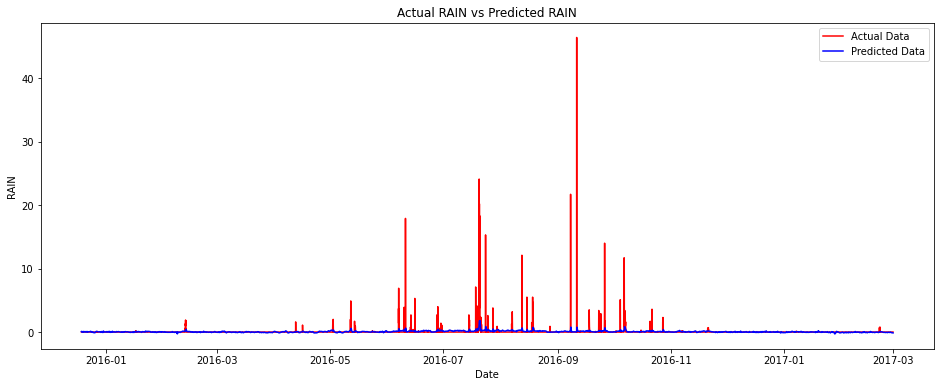

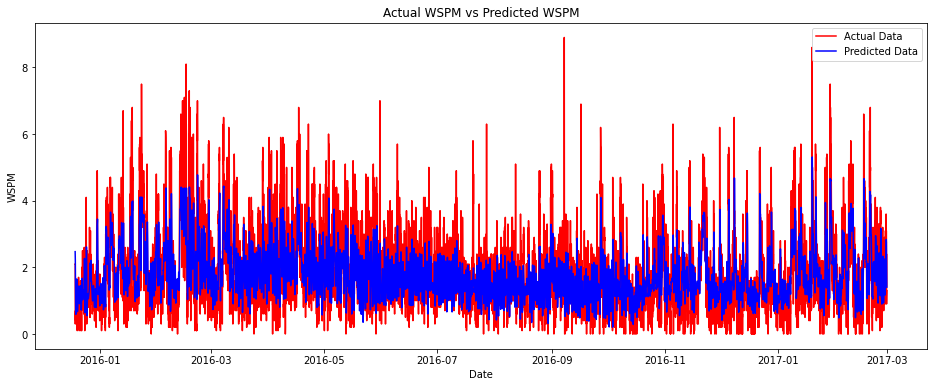

In [ ]:
plot_actual_pred(lstm_pred)